In [1]:
from i2.tests.util import mk_func_from_params
from i2 import Sig

f = mk_func_from_params('2244')
assert str(Sig(f)) == '(*a20, *a21, **a42, **a43)'
assert f(0,1,2,3, x=4, y=5) == "a20=(0, 1, 2, 3), a21=(), a42={}, a43={'x': 4, 'y': 5}"

ValueError: You can't have several variadic keywords: ('a20', 'a21')

In [1]:
from meshed import DAG, FuncNode


In [6]:
def f(a, **kwargs): # also test  the *args ! pb if f and g have kwargs (check "mk_all_pk" , or nice_kinds in i2)
    print(kwargs)
    return a

In [7]:
f_node = FuncNode(func=f)
d = DAG([f_node])  # breakpoint
    # args = ['a'=1]
    # kwargs = {'x'=3}

    # d(*args, **kwargs
scope = d.sig.kwargs_from_args_and_kwargs((), {"a": 1, "x": 3})

In [8]:
scope

{'a': 1, 'kwargs': {'x': 3}}

In [12]:
from i2 import kwargs_from_args_and_kwargs

ImportError: cannot import name 'kwargs_from_args_and_kwargs' from 'i2' (/Users/sylvain/Desktop/dev/otosense/i2/i2/__init__.py)

In [17]:
from i2 import Sig
>>> def foo(w, /, x: float, y="YY", *, z: str = "ZZ"):
        pass     
>>> sig = Sig(foo)
>>> assert (sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo"))
         == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
         == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
     )
        

In [197]:
from i2 import Sig
def foo(w, /, x: float, y="YY", *, z: str = "ZZ", **rest):
        pass     
sig = Sig(foo)
#assert (sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo", other="stuff"))
#         == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
#         == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
#     )

In [198]:
sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo", other="stuff"))

{'w': 11, 'x': 22, 'y': 'you', 'z': 'zoo', 'rest': {'other': 'stuff'}}

In [199]:
from i2.signatures import VK

def maybe_first(items):
    return items[0] if items else None
    
def name_of_var_kw_argument(sig):
    var_kw_list = [param.name for param in sig.params if param.kind == VK] 
    result = maybe_first(var_kw_list)
    return result

def map_action_on_cond(kvs, cond, expand):
    for k,v in kvs:
        if cond(k):
            yield from expand(v)
        else:
            yield k,v

def flatten_if_var_kw(kvs, var_kw_name):
    cond = lambda k:k==var_kw_name
    expand = lambda k:k.items()

    return map_action_on_cond(kvs, cond, expand)

In [208]:
def kwargs_from_args_and_kwargs(
        self,
        args,
        kwargs,
        *,
        apply_defaults=False,
        allow_partial=False,
        allow_excess=False,
        ignore_kind=False,
        post_process = False
    ):
        """Extracts a dict of input argument values for target signature, from args
        and kwargs.

        When you need to manage how the arguments of a function are specified,
        you need to take care of
        multiple cases depending on whether they were specified as positional arguments
        (`args`) or keyword arguments (`kwargs`).

        The `kwargs_from_args_and_kwargs` (and it's sorta-inverse inverse,
        `args_and_kwargs_from_kwargs`)
        are there to help you manage this.

        If you could rely on the the fact that only `kwargs` were given it would
        reduce the complexity of your code.
        This is why we have the `all_pk_signature` function in `signatures.py`.

        We also need to have a means to make a `kwargs` only from the actual `(*args,
        **kwargs)` used at runtime.
        We have `Signature.bind` (and `bind_partial`) for that.

        But these methods will fail if there is extra stuff in the `kwargs`.
        Yet sometimes we'd like to have a `dict` that services several functions that
        will extract their needs from it.

        That's where  `Sig.extract_kwargs(*args, **kwargs)` is needed.
        :param args: The args the function will be called with.
        :param kwargs: The kwargs the function will be called with.
        :param apply_defaults: (bool) Whether to apply signature defaults to the
        non-specified argument names
        :param allow_partial: (bool) True iff you want to allow partial signature
        fulfillment.
        :param allow_excess: (bool) Set to True iff you want to allow extra kwargs
        items to be ignored.
        :param ignore_kind: (bool) Set to True iff you want to ignore the position and
        keyword only kinds,
            in order to be able to accept args and kwargs in such a way that there can
            be cross-over
            (args that are supposed to be keyword only, and kwargs that are supposed
            to be positional only)
        :return: An {argname: argval, ...} dict

        See also the sorta-inverse of this function: args_and_kwargs_from_kwargs

        >>> def foo(w, /, x: float, y="YY", *, z: str = "ZZ"):
        ...     ...
        >>> sig = Sig(foo)
        >>> assert (
        ...     sig.kwargs_from_args_and_kwargs((11, 22, "you"), dict(z="zoo"))
        ...     == sig.kwargs_from_args_and_kwargs((11, 22), dict(y="you", z="zoo"))
        ...     == {"w": 11, "x": 22, "y": "you", "z": "zoo"}
        ... )

        By default, `apply_defaults=False`, which will lead to only get those
        arguments you input.

        >>> sig.kwargs_from_args_and_kwargs(args=(11,), kwargs={"x": 22})
        {'w': 11, 'x': 22}

        But if you specify `apply_defaults=True` non-specified non-require arguments
        will be returned with their defaults:

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22}, apply_defaults=True
        ... )
        {'w': 11, 'x': 22, 'y': 'YY', 'z': 'ZZ'}

        By default, `ignore_excess=False`, so specifying kwargs that are not in the
        signature will lead to an exception.

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22, "not_in_sig": -1}
        ... )
        Traceback (most recent call last):
            ...
        TypeError: Got unexpected keyword arguments: not_in_sig

        Specifying `allow_excess=True` will ignore such excess fields of kwargs.
        This is useful when you want to source several functions from a same dict.

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(11,), kwargs={"x": 22, "not_in_sig": -1}, allow_excess=True
        ... )
        {'w': 11, 'x': 22}

        On the other side of `ignore_excess` you have `allow_partial` that will allow
        you, if
        set to `True`, to underspecify the params of a function (in view of being
        completed later).

        >>> sig.kwargs_from_args_and_kwargs(args=(), kwargs={"x": 22})
        Traceback (most recent call last):
          ...
        TypeError: missing a required argument: 'w'

        But if you specify `allow_partial=True`...

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(), kwargs={"x": 22}, allow_partial=True
        ... )
        {'x': 22}

        That's a lot of control (eight combinations total), but not everything is
        controllable here:
        Position only and keyword only kinds need to be respected:

        >>> sig.kwargs_from_args_and_kwargs(args=(1, 2, 3, 4), kwargs={})
        Traceback (most recent call last):
          ...
        TypeError: too many positional arguments
        >>> sig.kwargs_from_args_and_kwargs(args=(), kwargs=dict(w=1, x=2, y=3, z=4))
        Traceback (most recent call last):
          ...
        TypeError: 'w' parameter is positional only, but was passed as a keyword

        But if you want to ignore the kind of parameter, just say so:

        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(1, 2, 3, 4), kwargs={}, ignore_kind=True
        ... )
        {'w': 1, 'x': 2, 'y': 3, 'z': 4}
        >>> sig.kwargs_from_args_and_kwargs(
        ...     args=(), kwargs=dict(w=1, x=2, y=3, z=4), ignore_kind=True
        ... )
        {'w': 1, 'x': 2, 'y': 3, 'z': 4}
        """
        no_var_kw = not self.has_var_keyword
        #no_var_kw = True


        if ignore_kind:
            sig = self.normalize_kind(
                # except_kinds=frozenset()
            )
        else:
            sig = self

        # no_var_kw = not sig.has_var_keyword TODOD check this
        if no_var_kw:  # has no var keyword kinds
            sig_relevant_kwargs = {
                name: kwargs[name] for name in sig if name in kwargs
            }  # take only what you need
        else:
            sig_relevant_kwargs = kwargs  # take all the kwargs
        binder = sig.bind_partial if allow_partial else sig.bind
        if not self.has_var_positional and allow_excess:
            max_allowed_num_of_posisional_args = sum(
                k <= PK for k in self.kinds.values()
            )
            args = args[:max_allowed_num_of_posisional_args]

        b = binder(*args, **sig_relevant_kwargs)
        if apply_defaults:
            b.apply_defaults()

        if no_var_kw and not allow_excess:  # don't ignore excess kwargs
            excess = kwargs.keys() - b.arguments
            if excess:
                excess_str = ', '.join(excess)
                raise TypeError(f'Got unexpected keyword arguments: {excess_str}')
        
        
        if post_process:
            var_kw_name = name_of_var_kw_argument(self)

            kvs = b.arguments.items()

            flattened_kvs = flatten_if_var_kw(kvs, var_kw_name)
            result = dict(flattened_kvs)

        else:
            result = b.arguments
        return result
        

In [209]:
sig, sig.has_var_keyword

(<Sig (w, /, x: float, y='YY', *, z: str = 'ZZ', **rest)>, True)

In [211]:
res = kwargs_from_args_and_kwargs(sig, (11, 22, "you"), dict(z="zoo", other="stuff"), post_process=True)
res

{'w': 11, 'x': 22, 'y': 'you', 'z': 'zoo', 'other': 'stuff'}

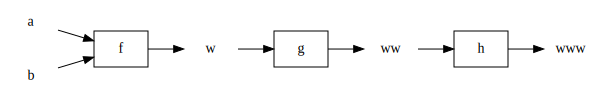

In [1]:
from meshed import code_to_dag

@code_to_dag
def dag():
    w = f(a, b)
    ww = g(c=w)
    www = h(x=ww)

dag.dot_digraph('rankdir="LR"')

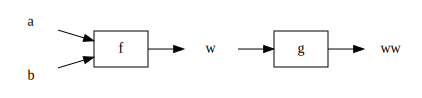

In [14]:
dag[['w']:'ww'].dot_digraph('rankdir="LR"')

In [8]:
def getitem2(self, item):
        """Get a sub-dag from a specification of (var or fun) input and output nodes.
        ``dag[input_nodes:output_nodes]`` is the sub-dag made of intersection of all
        descendants of ``input_nodes``
        (inclusive) and ancestors of ``output_nodes`` (inclusive), where additionally,
        when a func node is contained, it takes with it the input and output nodes
        it needs.
        >>> def f(a): ...
        >>> def g(f): ...
        >>> def h(g): ...
        >>> def i(h): ...
        >>> dag = DAG([f, g, h, i])
        See what this dag looks like (it's a simple pipeline):
        >>> dag = DAG([f, g, h, i])
        >>> print(dag.synopsis_string())
        a -> f_ -> f
        f -> g_ -> g
        g -> h_ -> h
        h -> i_ -> i
        Get a subdag from ``g_`` (indicates the function here) to the end of ``dag``
        >>> subdag = dag['g_':]
        >>> print(subdag.synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        h -> i_ -> i
        From the beginning to ``h_``
        >>> print(dag[:'h_'].synopsis_string())
        a -> f_ -> f
        f -> g_ -> g
        g -> h_ -> h
        From ``g_`` to ``h_`` (both inclusive)
        >>> print(dag['g_':'h_'].synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        Above we used function (node names) to specify what we wanted, but we can also
        use names of input/output var-nodes. Do note the difference though.
        The nodes you specify to get a sub-dag are INCLUSIVE, but when you
        specify function nodes, you also get the input and output nodes of these
        functions.
        The ``dag['g_', 'h_']`` give us a sub-dag starting at ``f`` (the input node),
        but when we ask ``dag['g', 'h_']`` instead, ``g`` being the output node of
        function node ``g_``, we only get ``g -> h_ -> h``:
        >>> print(dag['g':'h'].synopsis_string())
        g -> h_ -> h
        If we wanted to include ``f`` we'd have to specify it:
        >>> print(dag['f':'h'].synopsis_string())
        f -> g_ -> g
        g -> h_ -> h
        Those were for simple pipelines, but let's now look at a more complex dag.
        We'll let the following examples self-comment:
        >>> def f(u, v): ...
        >>> def g(f): ...
        >>> def h(f, w): ...
        >>> def i(g, h): ...
        >>> def j(h, x): ...
        >>> def k(i): ...
        >>> def l(i, j): ...
        >>> dag = DAG([f, g, h, i, j, k, l])
        >>> print(dag.synopsis_string())
        u,v -> f_ -> f
        f,w -> h_ -> h
        h,x -> j_ -> j
        f -> g_ -> g
        g,h -> i_ -> i
        i,j -> l_ -> l
        i -> k_ -> k
        A little util to get consistent prints:
        >>> def print_sorted_synopsis(dag):
        ...     t = sorted(dag.synopsis_string().split('\\n'))
        ...     print('\\n'.join(t))
        >>> print_sorted_synopsis(dag[['u', 'f']:'h'])
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag['u':'h'])
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag[['u', 'f']:['h', 'g']])
        f -> g_ -> g
        f,w -> h_ -> h
        u,v -> f_ -> f
        >>> print_sorted_synopsis(dag[['x', 'g']:'k'])
        g,h -> i_ -> i
        i -> k_ -> k
        >>> print_sorted_synopsis(dag[['x', 'g']:['l', 'k']])
        g,h -> i_ -> i
        h,x -> j_ -> j
        i -> k_ -> k
        i,j -> l_ -> l
        >>>
        """
        return self._getitem(item)

def _getitem(self, item):
        ins, outs = self.process_item(item)
        print(ins)
        _descendants = set(
            filter(FuncNode.has_as_instance, set(ins) | descendants(self.graph, ins))
        )
        _ancestors = set(
            filter(FuncNode.has_as_instance, set(outs) | ancestors(self.graph, outs))
        )
        subgraph_nodes = _descendants.intersection(_ancestors)
        # TODO: When clone ready, use to do `constructor = type(self)` instead of DAG
        # constructor = type(self)  # instead of DAG
        initial_nodes = self.func_nodes
        ordered_subgraph_nodes = order_subset_from_list(initial_nodes, subgraph_nodes)

        return DAG(
            func_nodes=ordered_subgraph_nodes,
            cache_last_scope=self.cache_last_scope,
            parameter_merge=self.parameter_merge,
        )

In [12]:
type(dag).__getitem__ = getitem2

In [13]:
dag['w':'ww']

DAG(func_nodes=[FuncNode(a,b -> f -> w), FuncNode(c=w -> g -> ww)], name=None)

In [20]:
from meshed import DAG

In [23]:
        >>> def f(a): ...
        >>> def g(f): ...
        >>> def h(g): ...
        >>> def i(h): ...
        >>> dag = DAG([f, g, h, i])
        #See what this dag looks like (it's a simple pipeline):
        >>> dag = DAG([f, g, h, i])
        #>>> print(dag.synopsis_string())
        #a -> f_ -> f
        #f -> g_ -> g
        #g -> h_ -> h
        #h -> i_ -> i
        #Get a subdag from ``g_`` (indicates the function here) to the end of ``dag``
        >>> subdag = dag['g_':]
        #>>> print(subdag.synopsis_string())
        #f -> g_ -> g
        #g -> h_ -> h
        #h -> i_ -> i
        #From the beginning to ``h_``
        #>>> print(dag[:'h_'].synopsis_string())
        #a -> f_ -> f
        #f -> g_ -> g
        #g -> h_ -> h
        #From ``g_`` to ``h_`` (both inclusive)
        #>>> print(dag['g_':'h_'].synopsis_string())
        >>> print(dag['g':'h_'].synopsis_string())

f -> g_ -> g
g -> h_ -> h


# Check the Subdags

In [25]:
from scrap_dag import DAG as MDAG

In [ ]:
#def w = f(a, b)
#    ww = g(c=w)
#    www = h(x=ww)

# get_node_matching versus func_node_for

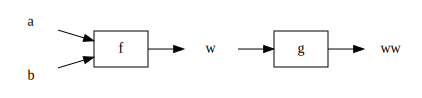

In [2]:
from meshed import code_to_dag

@code_to_dag
def dag():
    w = f(a, b)
    ww = g(c=w)
    #www = h(x=ww)

dag.dot_digraph('rankdir="LR"')

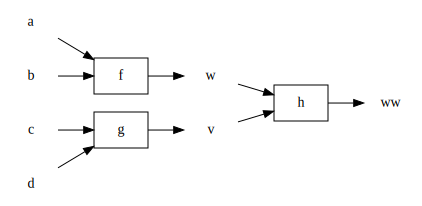

In [27]:
from meshed import DAG

@code_to_dag
def dag():
    w = f(a, b)
    v = g(c,d)
    ww = h(w,v)


dag.dot_digraph('rankdir="LR"')

In [85]:
dag.get_node_matching('ww')

'ww'

In [86]:
dag._func_node_for['ww']

FuncNode(w,v -> h -> ww)

In [88]:
dag.process_item(slice('w','ww'))

(['w'], ['ww'])

In [75]:
from typing import Callable, Iterable
from meshed.util import (
    lambda_name,
    ValidationError,)

def process_item_mod(self, item):
        assert isinstance(item, slice), f'must be a slice, was: {item}'

        input_names, outs = item.start, item.stop

        empty_slice = slice(None)

        def ensure_variable_list(obj):
            if obj is None:
                return self.var_nodes
            if isinstance(obj, str):
                obj = obj.split()
            if isinstance(obj, (str, Callable)):
                # TODO: See if we can use _func_node_for instead
                print('isinstance(obj, (str, Callable)?')
                return [self._func_node_for(obj)]
                #return [self.get_node_matching(obj)]
            elif isinstance(obj, Iterable):
                # TODO: See if we can use _func_node_for instead
                #print('isinstance(obj, Iterable))?')

                return list(map(self.get_node_matching, obj))
                #func = lambda k:self._func_node_for[k]
                #return list(map(func, obj))

            else:
                raise ValidationError(f'Unrecognized variables specification: {obj}')

        # assert len(item) == 2, f"Only items of size 1 or 2 are supported"
        input_names, outs = map(ensure_variable_list, [input_names, outs])
        return input_names, outs

Careful: what happens if we use an output name? 

In [76]:
dag.get_node_matching('w'), dag._func_node_for['w']

('w', FuncNode(a,b -> f -> w))

In [77]:
process_item_mod(dag,slice('w',None))

(['w'], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])

In [79]:
# shouldn't we return all leaves only (and not also the roots)?
# Using get_node_matching
#(['w'], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])
# Using _func_node_for
#assert str(process_item_mod(dag,slice('w',None))) == "([FuncNode(a,b -> f -> w)], ['d', 'c', 'v', 'b', 'a', 'w', 'ww'])"

In [92]:
subdag = dag['w':'ww']
subdag

DAG(func_nodes=[FuncNode(w,v -> h -> ww)], name=None)

In [90]:
subdag.dot_digraph('rankdir="LR"')

In [ ]:
    def get_node_matching(self, pattern):
        if isinstance(pattern, str):
            if pattern in self.var_nodes:
                return pattern
            return self.func_node_for_name(pattern)
        elif isinstance(pattern, Callable):
            return self.func_node_for_func(pattern)
        raise NotFound(f'No matching node: {pattern}')

    def func_node_for_name(self, name):
        return _find_unique_element(
            name, self.func_nodes, lambda name, fn: name == fn.name
        )

    def func_node_for_func(self, func):
        return _find_unique_element(
            func, self.func_nodes, lambda func, fn: func == fn.func
        )

    # TODO: Reflect: Should we include functions as keys here? Makes existence of the
    #  item depend on unicity of the function in the DAG, therefore dynamic, so instable?
    @cached_property
    def _func_node_for(self):
        """A dictionary mapping identifiers and functions to their FuncNode instances
        in the DAG. The keys of this dictionary will include:

        - identifiers (names) of the ``FuncNode`` instances
        - ``out`` of ``FuncNode`` instances
        - The ``.func`` of the ``FuncNode`` instances if it's unique.

        >>> def foo(x): return x + 1
        >>> def bar(x): return x * 2
        >>> dag = DAG([
        ...     FuncNode(foo, out='foo_output'),
        ...     FuncNode(bar, name='B', out='b', bind={'x': 'foo_output'}),
        ... ])

        A ``FuncNode`` instance is indexed by both its identifier (``.name``) as well as
        the identifier of it's output (``.out``):

        >>> dag._func_node_for['foo_output']
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for['foo']
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for['b']
        FuncNode(x=foo_output -> B -> b)
        >>> dag._func_node_for['B']
        FuncNode(x=foo_output -> B -> b)

        If the function is hashable (most are) and unique within the ``DAG``, you
        can also find the ``FuncNode`` via the ``.func`` it's wrapping:

        >>> dag._func_node_for[foo]
        FuncNode(x -> foo -> foo_output)
        >>> dag._func_node_for[bar]
        FuncNode(x=foo_output -> B -> b)

        A word of warning though: The function index is provided as a convenience, but
        using identifiers is preferable since referencing via the function object
        depends on the other functions of the DAG, so could change if we add nodes.
        
        """
        d = dict()
        for func_node in self.func_nodes:
            d[func_node.out] = func_node
            d[func_node.name] = func_node

            try:
                if func_node.func not in d:
                    # if .func not in d already, remember the link
                    d[func_node.func] = func_node
                else:
                    # if .func was already in there, mark it for removal
                    # (but leaving the key present so that we know about the duplication)
                    d[func_node.func] = None
            except TypeError:
                # ignore (and don't include func) if not hashable
                pass

        # remove the items marked for removal and return
        return {k: v for k, v in d.items() if v is not None}

In [100]:
    >>> from meshed import FuncNode
    >>> from meshed.dag import dot_lines_of_func_nodes
    >>> def add(a, b=1):
    ...     return a + b
    >>> def mult(x, y=3):
    ...     return x * y
    >>> def exp(mult, a):
    ...     return mult ** a
    >>> func_nodes = [
    ...     FuncNode(add, out='x'),
    ...     FuncNode(mult, name='the_product'),
    ...     FuncNode(exp)
    ... ]
    >>> lines = list(dot_lines_of_func_nodes(func_nodes))
    
    

In [101]:
lines

['x [label="x" shape="none"]',
 'add [label="add" shape="box"]',
 'add -> x',
 'a [label="a" shape="none"]',
 'b [label="b=" shape="none"]',
 'a -> add',
 'b -> add',
 '_the_product [label="_the_product" shape="none"]',
 'the_product [label="the_product" shape="box"]',
 'the_product -> _the_product',
 'x [label="x" shape="none"]',
 'y [label="y=" shape="none"]',
 'x -> the_product',
 'y -> the_product',
 'exp [label="exp" shape="none"]',
 'exp_ [label="exp_" shape="box"]',
 'exp_ -> exp',
 'mult [label="mult" shape="none"]',
 'a [label="a" shape="none"]',
 'mult -> exp_',
 'a -> exp_']

In [1]:
import networkx as nx
import nx_altair as nxa

# Generate a random graph
G = nx.fast_gnp_random_graph(n=20, p=0.25)

# Compute positions for viz.
pos = nx.spring_layout(G)

# Draw the graph using Altair
viz = nxa.draw_networkx(G, pos=pos)

# Show it as an interactive plot!
viz.interactive()

alt.LayerChart(...)

# Investigate bug found by Christian

[-0.07727463 -1.70282303  0.54470656 -1.59983573 -2.43078812 -0.76257361
 -9.40758377  0.92845651 -2.38447092 -3.46420471  1.20634945 -1.87438552
 -4.31889317 -3.58112916 -5.93352567 -5.64824571 -1.32973512 -2.05526387
 -4.82245739 -0.63525052 -4.32398153 -5.45553545 -3.83469213 -3.33861056
  0.31143918 -2.68501259  0.67469432  1.52745041 -1.0230247  -0.82452526
 -1.09806105 -5.08931187 -1.38268629  1.58275134 -2.58355018 -5.13646597
  0.37212398  0.69934848  0.49227692  2.24153803  0.54916077 -1.20032917
 -1.20005918 -5.1141437  -4.02706779 -3.20708651 -0.20836563 -2.80321702
 -3.68373874  1.99916906 -3.49082031 -0.69965971  1.42190204 -6.79183758
 -2.87814101  2.43926124 -3.00360032 -0.76250378 -0.38213634 -6.8832923
 -4.60943218 -2.70143945 -0.59509411  0.66691442 -2.37644894 -4.92906517
 -5.13901741 -1.30962532 -4.39982798 -6.62426858  0.44006081 -3.00996701
 -4.88203283 -3.97364611 -0.41200419 -6.77362497 -2.99515502 -4.35335371
 -6.96804392  0.40395758 -3.42295285 -0.55223192  0.

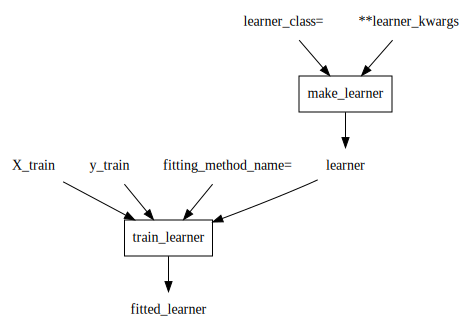

In [1]:
from functools import partial

from meshed import DAG, FuncNode
from sklearn.decomposition import PCA
import numpy as np


X_train = np.random.random((100, 30))
y_train = None
X_run = np.random.random((20, 30))


def make_learner_(learner_class,
                  **learner_kwargs):
    model = learner_class
    # instantiate the learner
    learner_instance = model(**learner_kwargs)
    return learner_instance


def make_learner_node(learner_class,
                      name='make_learner',
                      output_name='learner',
                      **learner_kwargs):
    learner_ = partial(make_learner_, learner_class=learner_class)
    return FuncNode(func=learner_,
                    name=name,
                    out=output_name)


def make_train_learner_(learner, X_train, y_train, fitting_method_name='fit'):
    fitting_method = getattr(learner, fitting_method_name)
    fitted_learner = fitting_method(X_train, y_train)
    return fitted_learner


def make_train_learner_node(learner_bind='learner',
                            X_train_bind='X_train',
                            y_train_bind='y_train',
                            fitting_method_name='fit',
                            name='train_learner'):
    make_train_learner__ = partial(make_train_learner_, fitting_method_name=fitting_method_name)
    return FuncNode(func=make_train_learner__,
                    name=name,
                    bind={'learner': learner_bind, 'X_train': X_train_bind, 'y_train': y_train_bind},
                    out='fitted_learner')


def make_fitter_and_runner_nodes_(
        model,
        fit_bind='fit',
        transform_bind='transform',
        **model_kwargs,
):
    learner_node = make_learner_node(model, **model_kwargs)
    training_node = make_train_learner_node(learner_bind='learner')

    return learner_node, training_node  # WTF, Commenting the training node make the DAG d_2 fail to construct!


d_2 = DAG(make_fitter_and_runner_nodes_(model=PCA,
                                        transform_bind='score_samples'))

print(d_2(X_train, y_train).score_samples(X_train))



# in meshed: _allow_reordering = True in "modified" method of dag
d_2.dot_digraph()

In [3]:
body = d_2.dot_digraph_body()
body

<generator object DAG.dot_digraph_body at 0x7fac86c2f120>

In [4]:
from meshed.dag import dot_lines_of_func_nodes
dlines = dot_lines_of_func_nodes(d_2.func_nodes, start_lines=())
list(dlines)

['learner [label="learner" shape="none"]',
 'make_learner [label="make_learner" shape="box"]',
 'make_learner -> learner',
 'learner_class [label="learner_class=" shape="none"]',
 'learner_kwargs [label="**learner_kwargs" shape="none"]',
 'learner_class -> make_learner',
 'learner_kwargs -> make_learner',
 'fitted_learner [label="fitted_learner" shape="none"]',
 'train_learner [label="train_learner" shape="box"]',
 'train_learner -> fitted_learner',
 'learner [label="learner" shape="none"]',
 'X_train [label="X_train" shape="none"]',
 'y_train [label="y_train" shape="none"]',
 'fitting_method_name [label="fitting_method_name=" shape="none"]',
 'learner -> train_learner',
 'X_train -> train_learner',
 'y_train -> train_learner',
 'fitting_method_name -> train_learner']

dot_digraph
--(calls)--> dot_digraph_body
--(calls)--> dot_lines_of_func_nodes(d_2.func_nodes, start_lines=()) 
--(calls)--> dot_lines_of_func_node(fnode) # where fnode = d_2.func_nodes[0]
--(calls)--> params = fnode.sig.ch_names(fnode.sig, **fnode.bind).params  
--(calls)--> self.ch_param_attrs('name', **changes_for_name)
--(calls)--> all_pk_self = self.modified(**{name: {'kind': PK} for name in self.names})

self.ch_params_attrs needs to be called with _allow_reordering=True instead of False

# Dag templates

[ -5.66037846  -4.29589733  -4.47229006  -5.11112918  -1.23521284
  -3.31921439  -0.61181397  -1.94183937  -5.00147548   0.87248731
  -1.2622775   -3.79686658  -2.63550354  -4.84303264  -3.3123678
  -4.08070062  -5.821685    -2.72289842  -7.16608523  -6.32246763
  -2.26328288  -5.20802194  -2.76954919  -2.55063726  -3.47321808
  -1.07133924   0.27667122   0.62981354   0.46446921  -4.26206056
  -0.59720137  -3.40250452  -2.53156808  -2.57331459  -2.99843462
  -0.87399318  -1.28440894  -0.76918218  -3.31744391  -1.39226801
  -1.90197864  -6.19881001  -7.84508559  -3.14337609  -4.81354836
  -5.52345529  -0.97461507  -1.0645402   -5.01864395  -4.18986854
   2.40632255  -1.98457003  -1.06646881 -10.73000574  -2.78519377
   0.55958619   1.39974872  -0.76013598  -1.01066146  -2.18439999
  -5.22370817  -1.61129116  -1.51592227  -1.32999222  -3.1521465
  -6.92470121  -6.10378988  -1.30013672   1.60486787  -3.53033494
  -0.93748294   0.12308953  -7.14657847   1.10521956  -4.14908835
  -0.6169546

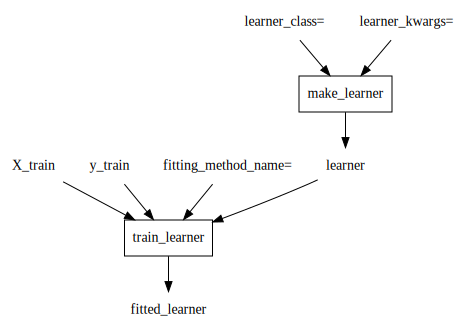

In [3]:

from functools import partial

from meshed import DAG, FuncNode
from sklearn.decomposition import PCA
import numpy as np


X_train = np.random.random((100, 30))
y_train = None
X_run = np.random.random((20, 30))


def make_learner_(learner_class,
                  **learner_kwargs):
    model = learner_class
    # instantiate the learner
    learner_instance = model(**learner_kwargs)
    return learner_instance


def make_learner_node(learner_class,
                      name='make_learner',
                      output_name='learner',
                      **learner_kwargs):
    learner_ = partial(make_learner_, learner_class=learner_class)
    return FuncNode(func=learner_,
                    name=name,
                    out=output_name)


def make_train_learner_(learner, X_train, y_train, fitting_method_name='fit'):
    fitting_method = getattr(learner, fitting_method_name)
    fitted_learner = fitting_method(X_train, y_train)
    return fitted_learner


def make_train_learner_node(learner_bind='learner',
                            X_train_bind='X_train',
                            y_train_bind='y_train',
                            fitting_method_name='fit',
                            name='train_learner'):
    make_train_learner__ = partial(make_train_learner_, fitting_method_name=fitting_method_name)
    return FuncNode(func=make_train_learner__,
                    name=name,
                    bind={'learner': learner_bind, 'X_train': X_train_bind, 'y_train': y_train_bind},
                    out='fitted_learner')


def make_fitter_and_runner_nodes_(
        model,
        fit_bind='fit',
        transform_bind='transform',
        **model_kwargs,
):
    learner_node = make_learner_node(model, **model_kwargs)
    training_node = make_train_learner_node(learner_bind='learner')

    return learner_node, training_node  # WTF, Commenting the training node make the DAG d_2 fail to construct!


d_2 = DAG(make_fitter_and_runner_nodes_(model=PCA,
                                        transform_bind='score_samples'))

print(d_2(X_train, y_train).score_samples(X_train))

d_2.dot_digraph()





In [9]:



d_1 = DAG(make_fitter_and_runner_nodes_(model=PCA))


d = d_1 + d_2
# ValueError: You can't have several variadic keywords: ('learner_kwargsTEST', 'learner_kwargs')

In [8]:
d

DAG(func_nodes=[FuncNode(learner_class,learner_kwargs -> make_learner -> learner), FuncNode(learner,X_train,y_train,fitting_method_name -> train_learner -> fitted_learner)], name=None)

In [10]:
def foo(a=1, **vk):
     return a

def bar(b=2, **vk):
    return b 



In [13]:
res = DAG([foo]) + DAG([bar])

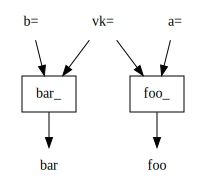

In [14]:
res.dot_digraph()

In [11]:
from i2 import Sig
def foo(x, y=1):
    return x + y

assert foo(0) == 1
bar = Sig(lambda x, y=2: None)(foo)
assert str(Sig(bar)) == '(x, y=2)'
assert bar(0) == 2

In [21]:
from meshed import DAG

def foo(x, y=1):
    return x + y

foo_dag = DAG([foo]) # cgange le __sig et le sig
assert foo_dag(0) == 1


In [22]:
bar_dag.sig, bar_dag.func.sig

AttributeError: 'DAG' object has no attribute 'func'

In [23]:
bar_dag.__signature__, bar_dag.sig

(<Signature (x, y=2)>, <Sig (x, y=1)>)

In [24]:
foo_dag.sig + (Sig(foo_dag.__signature__))

<Sig (x, y=1)>

In [33]:
bar_dag = Sig(lambda x, y=2: None)(foo_dag) # change le __signature__, mais pas le .sig
assert str(Sig(bar_dag)) == '(x, y=2)'
assert bar_dag(0) == 1  # BUT WE WANT THIS TO BE 2
# marche si tu bar_dag.sig

In [32]:
bar_dag.__defaults__, bar_dag.__signature__, bar_dag.__kwdefaults__
if self.sig != Sig(self.__signature__):
    self.sig = self

((2,), <Signature (x, y=2)>, {})

In [34]:
type(bar_dag.__signature__)

inspect.Signature

In [36]:
import inspect
isinstance(bar_dag.sig, inspect.Signature)

True

In [ ]:
* test equality: if different, set it to __signature__
* faire une property sig, pointing to __signature__  (add a deprecation warning)

@property
def sig(self):
    return Sig(self.__signature__)

In [31]:
bar_dag.sig

<Sig (x, y=1)>

In [ ]:
* in the call of a dag, make use of signature (the one that has been changed by the wrapping)
* nothing should change .sig (the one that is used in call)


# Simple dags for apps

In [3]:
from meshed.makers import code_to_dag
from itertools import chain
from functools import partial
import numpy as np
from meshed.makers import dlft_factory_to_func
from omodel.gen_utils.chunker import fixed_step_chunker 

from functools import partial
from omodel.outliers.pystroll import OutlierModel as Stroll

DFLT_CHK_SIZE = 2048
DFLT_CHK_STEP = 2048
DFLT_FEATURIZER = lambda chk: np.abs(np.fft.rfft(chk))


chunker = partial(
    fixed_step_chunker, chk_size=DFLT_CHK_SIZE, chk_step=DFLT_CHK_STEP
)
featurizer = DFLT_FEATURIZER

#fvs_train = np.array(list(map(DFLT_FEATURIZER, list_chks[:100])))

def call(func, arg):
    return func(arg)


def chained_map(func, iterable):
    return chain.from_iterable(map(func, iterable))

model = Stroll

@code_to_dag
def pipe():
    #wfs = call(src_to_wf, data_src)
    chks = chained_map(chunker, wfs)
    fvs = map(featurizer, chks)
    fitted_model = model.fit(fvs)
    model_outputs = model.score_samples(fvs)

AttributeError: 'Attribute' object has no attribute 'id'

In [ ]:
pipe.dot_digraph()